In [1]:
import pandas as pd
import xlrd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy import concatenate
import math
import re
import os 
import glob
import openpyxl

from datetime import datetime
from pandas import ExcelWriter
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
pwd

'/Users/shrilakshmisbonageri/Desktop/UW/DIRECT/PROJECT/Data/CX2_16'

In [4]:
path = '/Users/shrilakshmisbonageri/Desktop/UW/DIRECT/PROJECT/Data/CX2_16'
files = os.listdir(path)
excel_files = list(filter(lambda x: x[-5:]=='.xlsx' , files))
excel_files

fn = pd.DataFrame(data = excel_files,columns = ['file_name'])
fn['cell_type'],fn['cell_num'],fn['month'],fn['day'],fn['year'] = fn['file_name'].str.split('_', 4).str
fn['year'], fn['ext'] = fn['year'].str.split('.',1).str
fn.month = fn.month.astype(int)
fn.day = fn.day.astype(int)
fn.year = fn.year.astype(int)
fn['year'].replace(11,2011,inplace=True)
fn['year'].replace(12,2012,inplace=True)
fn['date']=''
fn['date']= fn['year'].map(str)+fn['month'].map(str)+fn['day'].map(str)
fn['date_time']=''
fn['date_time'] =  pd.to_datetime(fn['date'], format="%Y%m%d")
fn.sort_values(['date_time'],inplace=True)

In [5]:
ordered_names = fn['file_name'].values
df = {}
for i in range(0,len(ordered_names)):
    df[i] = pd.read_excel(ordered_names[i],sheet_name='Channel_1-006')
    

In [6]:
len(df)

51

In [7]:
df_cx16 = None
for k in range(0,len(df)):
    if df_cx16 is None:
        df_next = df[k]
        df_cx16 = pd.DataFrame(data=None, columns=df_next.columns)
        # df_next['Cycle'] = df_next['Cycle'] + max(df_pl12['Cycle'])
        df_cx16 = pd.concat([df_cx16, df_next])
    else:
        df_next = df[k]
        df_next['Cycle_Index'] = df_next['Cycle_Index'] + max(df_cx16['Cycle_Index'])
        df_cx16 = pd.concat([df_cx16, df_next])

In [8]:
df_cx16.head()

,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg)
0,1,30.000750,2011-02-04 17:19:22,29.937300,1,1,0.0,4.102870,0.0,0.0,0.0,0.0,0.000032,0.0,0,0,0
1,2,60.015904,2011-02-04 17:19:52,59.952454,1,1,0.0,4.102870,0.0,0.0,0.0,0.0,0.000032,0.0,0,0,0
2,3,90.030949,2011-02-04 17:20:22,89.967498,1,1,0.0,4.102870,0.0,0.0,0.0,0.0,0.000032,0.0,0,0,0
3,4,120.033724,2011-02-04 17:20:52,119.970274,1,1,0.0,4.103032,0.0,0.0,0.0,0.0,0.000032,0.0,0,0,0
4,5,120.072127,2011-02-04 17:20:52,120.008677,1,1,0.0,4.102870,0.0,0.0,0.0,0.0,0.000000,0.0,0,0,0


In [9]:
# Reset the index and drop the old index
df = df_cx16.reset_index(drop=True)

In [10]:
df

,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg)
0,1,30.000750,2011-02-04 17:19:22,29.937300,1,1,0.000000,4.102870,0.000000,0.000000,0.000000,0.000000,0.000032,0.000000,0,0,0
1,2,60.015904,2011-02-04 17:19:52,59.952454,1,1,0.000000,4.102870,0.000000,0.000000,0.000000,0.000000,0.000032,0.000000,0,0,0
2,3,90.030949,2011-02-04 17:20:22,89.967498,1,1,0.000000,4.102870,0.000000,0.000000,0.000000,0.000000,0.000032,0.000000,0,0,0
3,4,120.033724,2011-02-04 17:20:52,119.970274,1,1,0.000000,4.103032,0.000000,0.000000,0.000000,0.000000,0.000032,0.000000,0,0,0
4,5,120.072127,2011-02-04 17:20:52,120.008677,1,1,0.000000,4.102870,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0
5,6,171.182108,2011-02-04 17:21:44,30.014040,3,1,0.000000,4.113885,0.003955,0.000000,0.016576,0.000000,-0.000130,0.000000,0,0,0
6,7,201.197171,2011-02-04 17:22:14,60.029103,3,1,0.000000,4.110807,0.003955,0.000000,0.016576,0.000000,-0.000065,0.000000,0,0,0
7,8,231.212314,2011-02-04 17:22:44,90.044246,3,1,0.000000,4.109350,0.003955,0.000000,0.016576,0.000000,-0.000032,0.000000,0,0,0
8,9,261.180567,2011-02-04 17:23:14,120.012499,3,1,0.000000,4.108540,0.003955,0.000000,0.016576,0.000000,-0.000032,0.000000,0,0,0
9,10,261.180994,2011-02-04 17:23:14,0.000003,4,1,0.905961,4.201361,0.003955,0.000000,0.016576,0.000000,0.000000,0.000000,0,0,0


In [11]:
# Grouping rows by the cycle index.
group = df.groupby(['Cycle_Index']).count()
group.head()
group['Cumu_count'] = pd.Series(np.random.randn(len(group)), index=group.index)
group['Cumu_count'] = group['Data_Point'].cumsum()

In [12]:
df['Charge'] = pd.Series(np.random.randn(len(df)), index=df.index)
df['discharge'] = pd.Series(np.random.randn(len(df)), index=df.index)
cycle = []
cycle = group['Cumu_count']
df['Charge'][0:cycle[1]] = df['Charge_Capacity(Ah)'][0:cycle[1]]
df['discharge'][0:cycle[1]] = df['Discharge_Capacity(Ah)'][0:cycle[1]]

/Users/shrilakshmisbonageri/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/shrilakshmisbonageri/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
df['Charge'] = pd.Series(np.random.randn(len(df)), index=df.index)
df['discharge'] = pd.Series(np.random.randn(len(df)), index=df.index)
cycle = []
cycle = group['Cumu_count']
df['Charge'][0:cycle[1]] = df['Charge_Capacity(Ah)'][0:cycle[1]]
df['discharge'][0:cycle[1]] = df['Discharge_Capacity(Ah)'][0:cycle[1]]

/Users/shrilakshmisbonageri/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/shrilakshmisbonageri/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
# Saving the formatted dataframe
# writer = ExcelWriter('cx_16_concat.xlsx')
# df.to_excel(writer)
# writer.save()

In [15]:
# Dropping additional columns 
cycle_data = df.drop(['Data_Point','Internal_Resistance(Ohm)','Step_Index','Step_Time(s)','Charge_Capacity(Ah)','Discharge_Capacity(Ah)','Charge_Energy(Wh)','Discharge_Energy(Wh)','dV/dt(V/s)','Is_FC_Data','AC_Impedance(Ohm)','ACI_Phase_Angle(Deg)'],axis=1)
cycle_data['Capacity'] = pd.Series(np.random.randn(len(cycle_data)), index=cycle_data.index)
# Combining charge and discharge capacities to calculate net charge capacity of the battery.
cycle_data['Capacity'] = cycle_data['Charge'] - cycle_data['discharge']


In [16]:
# Dataframe for testing and training.
model_data = cycle_data.drop(['Charge','discharge','Test_Time(s)'],axis=1)
model_data.head()

,Date_Time,Cycle_Index,Current(A),Voltage(V),Capacity
0,2011-02-04 17:19:22,1,0.0,4.102870,0.0
1,2011-02-04 17:19:52,1,0.0,4.102870,0.0
2,2011-02-04 17:20:22,1,0.0,4.102870,0.0
3,2011-02-04 17:20:52,1,0.0,4.103032,0.0
4,2011-02-04 17:20:52,1,0.0,4.102870,0.0


/Users/shrilakshmisbonageri/miniconda3/envs/keras/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


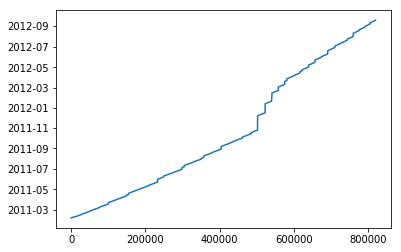

In [17]:
plt.plot(model_data['Date_Time'])

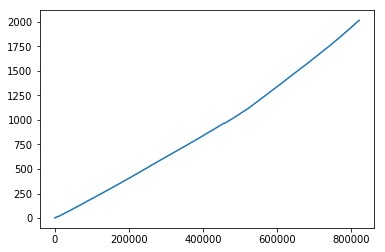

In [18]:
plt.plot(cycle_data['Cycle_Index'])